In [1]:
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")

In [2]:
import nearest_neighbors
reload(nearest_neighbors)

<module 'nearest_neighbors' from '/home/ecs-user/workspace/kNN-overlap-finder/notebooks/jit/../../scripts/nearest_neighbors.py'>

In [3]:
from data_io import is_fwd_id, get_fwd_id, get_sibling_id
from nearest_neighbors import (
    ExactNearestNeighbors,
    NNDescent,
    WeightedLowHash,
    JITWeightedLowHash,
    PAFNearestNeighbors,
    LowHash,
    HNSW,
    ProductQuantization,
    _NearestNeighbors,
)
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from truth import get_overlaps
from evaluate import NearestNeighborsConfig, mp_compute_nearest_neighbors
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/ecs-user/workspace/kNN-overlap-finder/scripts/../lib


## Parameters


In [4]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20

## Load data

In [5]:
npz_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_93_30k/kmer_k16/feature_matrix.npz"
tsv_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_93_30k/kmer_k16/metadata.tsv.gz"
json_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/feature_matrix/CHM13/IGK/pbsim_ONT_93_30k/kmer_k16/read_features.json.gz"
paf_path = "/home/ecs-user/workspace/kNN-overlap-finder/data/minimap2/CHM13/IGK/pbsim_ONT_93_30k/alignment.paf.gz"


In [6]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}

feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

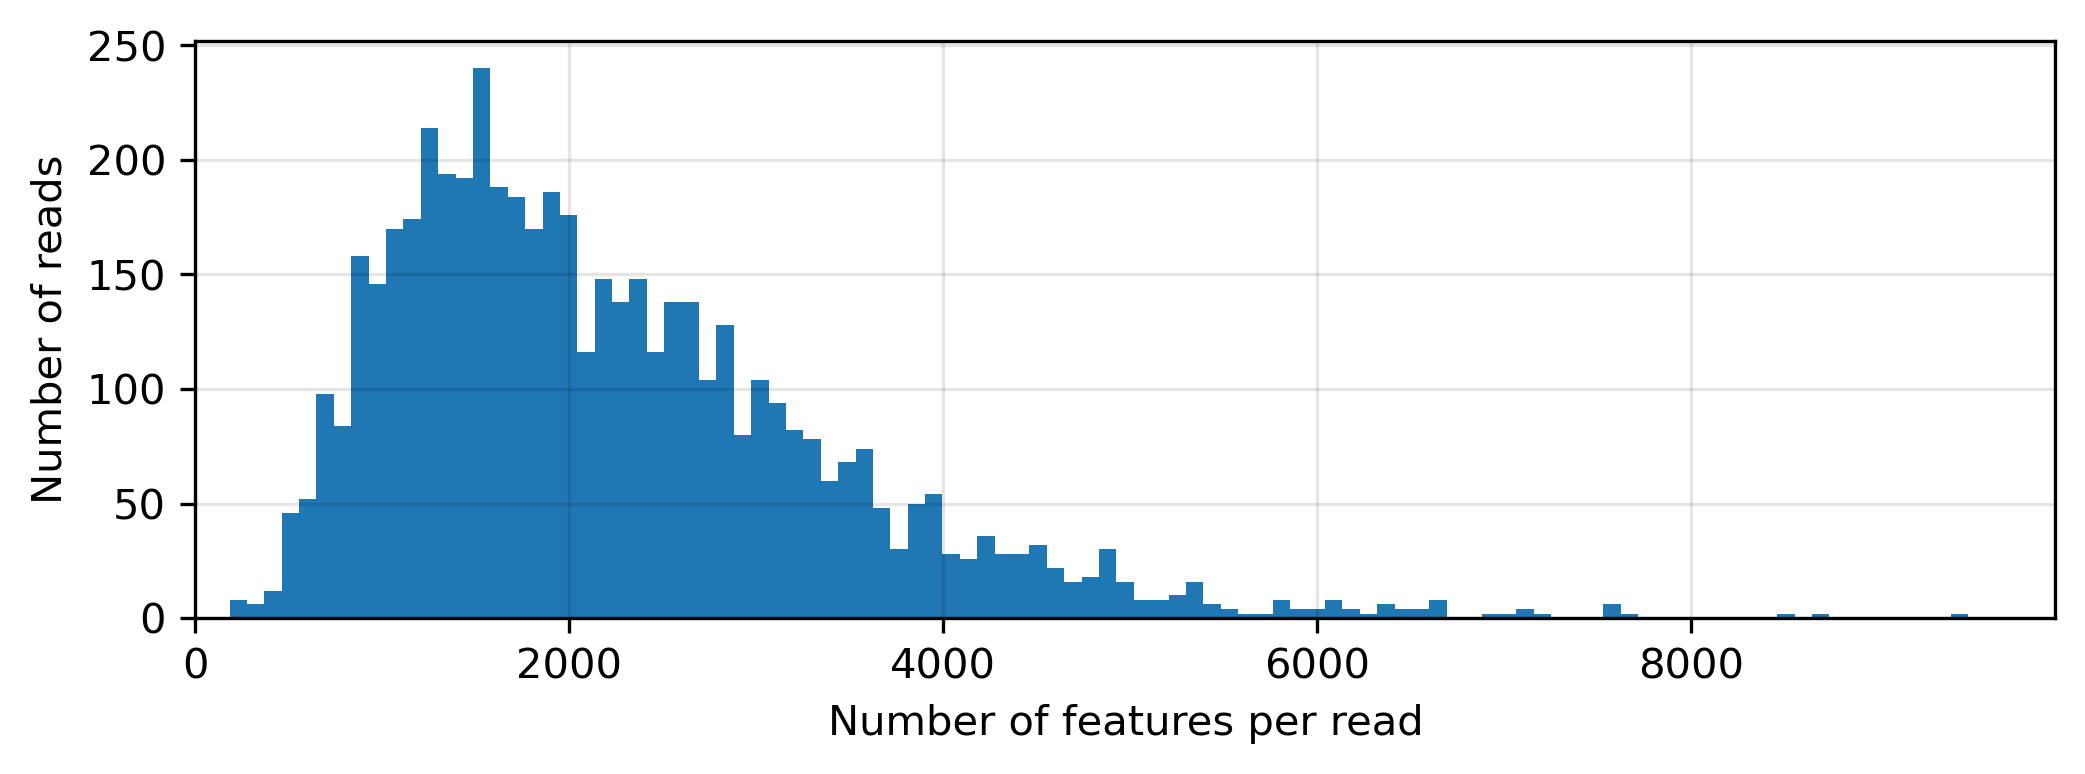

In [7]:
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.hist([len(x) for x in read_features.values()], bins=100)
ax.set_xlim(left=0)
ax.set_xlabel("Number of features per read")
ax.set_ylabel("Number of reads")
ax.grid(color='k', alpha=0.1)

In [8]:
feature_matrix.shape

(5106, 656109)

In [9]:
feature_matrix.sum() / (feature_matrix.shape[0] * feature_matrix.shape[1])

0.003394533678307444

In [10]:
meta_df

,index,read_id,read_name,read_orientation,read_length,reference_strand,reference_start,reference_end
0,0,0,S1_1,+,11173,+,3818817,3829989
1,1,1,S1_1,-,11173,-,3818817,3829989
2,2,2,S1_2,+,21867,-,3640734,3662730
3,3,3,S1_2,-,21867,+,3640734,3662730
4,4,4,S1_3,+,20113,+,2072903,2093713
...,...,...,...,...,...,...,...,...
5101,5101,5101,S1_2551,-,26580,-,2075897,2102673
5102,5102,5102,S1_2552,+,44667,-,3387382,3432227
5103,5103,5103,S1_2552,-,44667,+,3387382,3432227
5104,5104,5104,S1_2553,+,9939,+,268309,278309


In [11]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)
len(read_intervals)

5106

In [12]:
%%time
reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

CPU times: user 5.47 s, sys: 24.3 ms, total: 5.49 s
Wall time: 5.49 s


(5106, 103266, 9866, 2)

## Get nearest neighbours

In [16]:
kw = dict(data=feature_matrix)
max_bucket_size = COVERAGE_DEPTH * 1.5

configs = [
    NearestNeighborsConfig(
        method=WeightedLowHash,
        description="Weighted LowHash (TF)",
        tfidf=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
    NearestNeighborsConfig(
        method=a,
        description="Weighted LowHash (TF)",
        tfidf=False,
        nearest_neighbor_kw=dict(
            lowhash_fraction=0.01,
            max_bucket_size=max_bucket_size,
            repeats=100,
            seed=458,
        ),
        **kw
    ),
]

In [17]:
for i, config in enumerate(configs):
    print(i, config, sep='\t')

0	NearestNeighborsConfig(method=<class 'nearest_neighbors.WeightedLowHash'>, description='Weighted LowHash (TF)', binarize=False, tfidf=False, dim_reduction=None)
1	NearestNeighborsConfig(method=<class 'nearest_neighbors.JITWeightedLowHash'>, description='Weighted LowHash (TF)', binarize=False, tfidf=False, dim_reduction=None)


In [19]:
%%time

max_n_neighbors = COVERAGE_DEPTH
processes = 1

mp_compute_nearest_neighbors(data=feature_matrix, configs=configs, n_neighbors=max_n_neighbors, 
                            processes=processes)

Evaluating 2 configs using 1 processes.
0 0 1000 2000 3000 4000 5000 
Finished NearestNeighborsConfig(method=<class 'nearest_neighbors.WeightedLowHash'>, description='Weighted LowHash (TF)', binarize=False, tfidf=False, dim_reduction=None). Elapsed time: 111.83 s
1 0 1000 2000 3000 4000 5000 
Finished NearestNeighborsConfig(method=<class 'nearest_neighbors.JITWeightedLowHash'>, description='Weighted LowHash (TF)', binarize=False, tfidf=False, dim_reduction=None). Elapsed time: 112.18 s

CPU times: user 391 ms, sys: 52.2 ms, total: 443 ms
Wall time: 3min 44s


{0: array([[ 875,  547, 1391, ..., 3032,  600, 2408],
        [ 874, 2225,  546, ..., 2234,  601, 2409],
        [3305,  450,  846, ...,  773,   94,  677],
        ...,
        [4556, 2740, 4060, ..., 4036, 4427, 4684],
        [4291, 2483,  703, ..., 3815, 5060, 2563],
        [4290, 3186, 1234, ...,  845, 3814, 2562]]),
 1: array([[ 875,  547, 1391, ..., 3032,  600, 2408],
        [ 874, 2225,  546, ..., 2234,  601, 2409],
        [3305,  450,  846, ...,  773,   94,  677],
        ...,
        [4556, 2740, 4060, ..., 4036, 4427, 4684],
        [4291, 2483,  703, ..., 3815, 5060, 2563],
        [4290, 3186, 1234, ...,  845, 3814, 2562]])}

In [20]:
import scipy.sparse

# Create a sparse CSR matrix
x = scipy.sparse.csr_matrix([[1, 0, 0], [0, 2, 0], [0, 0, 3]])

# Transpose the matrix
x_transposed = x.T

# Check the type
print(type(x_transposed))  # Output: <class 'scipy.sparse.csr.csr_matrix'>


<class 'scipy.sparse._csc.csc_matrix'>


## Statistics

In [31]:
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)
for i, config in enumerate(configs):
    print(i, end=' ')
    for k in k_values:
        graph = config.get_overlap_graph(n_neighbors=k, read_ids=list(read_features), require_mutual_neighbors=False)
        graphs[i][k] = graph

0 

AttributeError: 'NearestNeighborsConfig' object has no attribute 'get_overlap_graph'

In [ ]:
df_rows = []
for i, config in enumerate(configs):
    print(i, end=' ')
    for k in k_values:
        graph = graphs[i][k]
        stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
        stats = {"config_id": i, "description": config.description, "n_neighbors": k, **stats}
        df_rows.append(stats)
df = pd.DataFrame(df_rows)
df['label'] = df['config_id'].map(str) + " " + df['description']
df['connected_fraction'] = 1 - df['singleton_fraction']

In [ ]:
y_labels = dict(
    precision="Precision",
    nr_recall="Recall (non-redundant overlaps)",
    N50="Graph N50 (after removing incorrect edges)",
    connected_fraction="Connected fraction (after removing incorrect edges)"
)

if len(configs) <= 10:
    palette = "tab10"
elif len(configs) <= 20:
    palette = 'tab20'
else:
    palette = 'rainbow'

fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)
for i, ax in enumerate( itertools.chain(*axes) ):
    y = list(y_labels)[i]
    x = 'n_neighbors'
    hue = 'label'
    g = seaborn.lineplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=palette)
    ax.set_xticks(k_values)
    ax.set_xlabel("Number of neighbors")
    ax.set_ylabel(y_labels[y])
    ax.grid(axis='both', color='k', alpha=0.1)

    if i == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    else:
        ax.get_legend().remove()

    ax.spines[['top', 'right']].set_visible(False)

## Graph visualisation

In [ ]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)

    for fig, config in zip(figures, configs):
        fig.suptitle(str(config), ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures

In [ ]:
%%time
k6_graphs = [graphs[i][6] for i in range(len(graphs))]
plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)

In [ ]:
%%time
k12_graphs = [graphs[i][6] for i in range(len(graphs))]
plot_graphs(
    k12_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=threads
)